In [1]:
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import show_doc
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2


# 3a Toy Data - Zhang et al's Adaptive PCA-based Scalar curvature
> 2 Manifolds, colored by curvature, neatly compared

Here is the curvature equivalent of the "sniff test": does our technique appropriately color the most basic 2 manifolds? This notebook implements this comparison, making it easy to swap in and out curvature methods and rerun them on every baseline.

In [2]:
use_heuristic = True
epsilon_PCA = 0.8
tau_radius = 1.5
# method_name = f"toy_datasets_principal_curvature_no_heuristic_08_15"
method_name = f"toy_datasets_principal_curvature_heuristic"

In [3]:
# Establish Datasets
load_from_saved = True
filename = "../../results/toy_data_saved_1000_more_noise"
if load_from_saved:
    Xs = np.load(filename + '.npz')
    Ks = np.load(filename + '_curvatures.npz')
else:
    n_points = 1000
    Xs = {}
    Ks = {}
    Xs['Torus'], Ks['Torus'] = torus(n_points, use_guide_points=False, seed=19323)
    Xs['plane'] = np.hstack([plane(n_points, dim=2),np.zeros((n_points,1))])
    Ks['plane'] = np.zeros(len(Xs['plane']))
    Xs['Saddle'], Ks['Saddle'] = paraboloid(n_points, use_guide_points=False, seed=19323)
    Xs['Sphere'], Ks['Sphere'] = sphere(n_points,)
    Xs['Ellipsoid'], Ks['Ellipsoid'] = ellipsoid(n_points, seed=19323)
    Xs['Hyperboloid'], Ks['Hyperboloid'] = hyperboloid(n_points, seed=19323)
    # Noised Versions
    for noise_scale in [0.1, 0.2, 0.3, 0.4, 0.5]: # [0.05, 0.1, 0.15, 0.2, 0.25]: 
        Xs[f'Torus noise = {noise_scale}'], Ks[f'Torus noise = {noise_scale}'] = torus(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
        # Xs['plane noise = {noise_scale}'] = np.hstack([plane(n_points, dim=2),np.zeros((n_points,1))])
        # Ks['plane noise = {noise_scale}'] = np.zeros(len(Xs['plane']))
        Xs[f'Saddle noise = {noise_scale}'], Ks[f'Saddle noise = {noise_scale}'] = paraboloid(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
        # Xs['sphere = {noise_scale}'], Ks['sphere = {noise_scale}'] = sphere(n_points,)
        Xs[f'Ellipsoid noise = {noise_scale}'], Ks[f'Ellipsoid noise = {noise_scale}'] = ellipsoid(n_points, seed=19323, noise = noise_scale)
        Xs[f'hyperboloid noise = {noise_scale}'], Ks[f'hyperboloid noise = {noise_scale}'] = hyperboloid(n_points, seed=19323, noise = noise_scale)
    np.savez(filename + '.npz', **Xs)
    np.savez(filename + '_curvatures.npz', **Ks)

In [4]:
# Xs = np.load("../../results/toy_data_saved.npz")
# Ks = np.load("../../results/toy_datasets_ground_truth_curvatures.npz")

# Run on Toy Datasets

In [5]:
from diffusion_curvature.benchmarking.zhang_principal_curvature import Gaussian_Curvature_2d 
from fastprogress.fastprogress import master_bar, progress_bar

In [6]:
diffusion_ks = {}

In [7]:
# set up progress bars
mb = master_bar(Xs.keys())

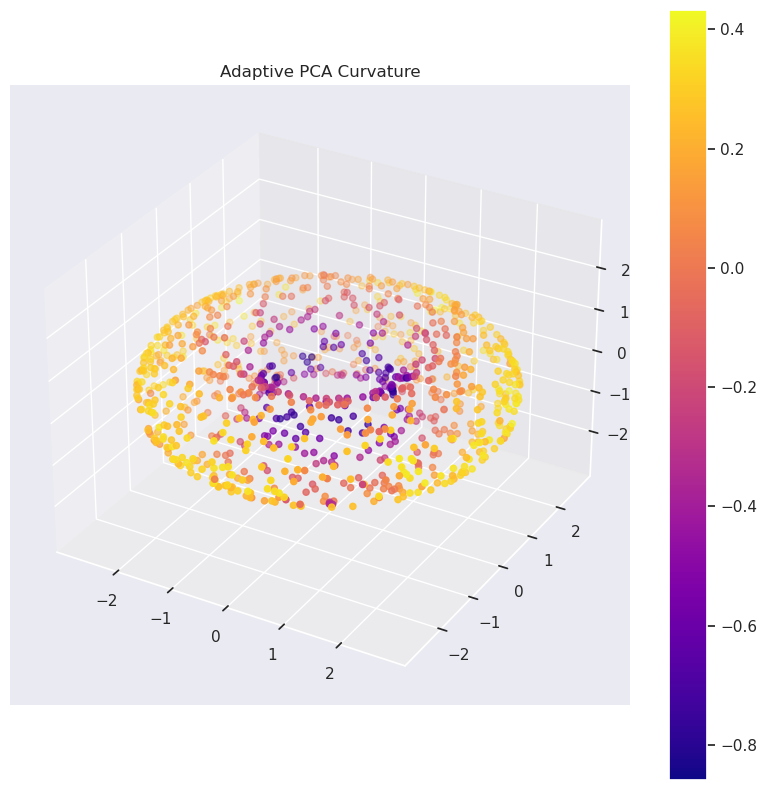

LinAlgError: SVD did not converge

In [8]:
for dname in mb:
    X = Xs[dname]
    # ks_computed = DC.curvature(G, dim=2, t=25)
    curvature = []
    num_eval = len(X)
    i_s = list(range(len(X)))
    pb = progress_bar(i_s, parent = mb)
    
        
    # curvature = parallel(curv_fn, i_s , n_workers=10, progress=pb)
    for i in pb:
        try:
            b = Gaussian_Curvature_2d(X, X[i].reshape(1, -1), prpl_percent = 0.3, use_heuristic = use_heuristic, epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
        except IndexError: # the point we're computing the curvature of is too far away from everything.
            b = 0
        curvature.append(b)
        
        
    ks_computed = np.array(curvature)
    
    diffusion_ks[dname] = ks_computed
    plot_3d(X, ks_computed, title = "Adaptive PCA Curvature", colorbar=True)
    # plot_3d(X, Ks[dname], title = "Gaussian Curvature", colorbar=True)


# Figure

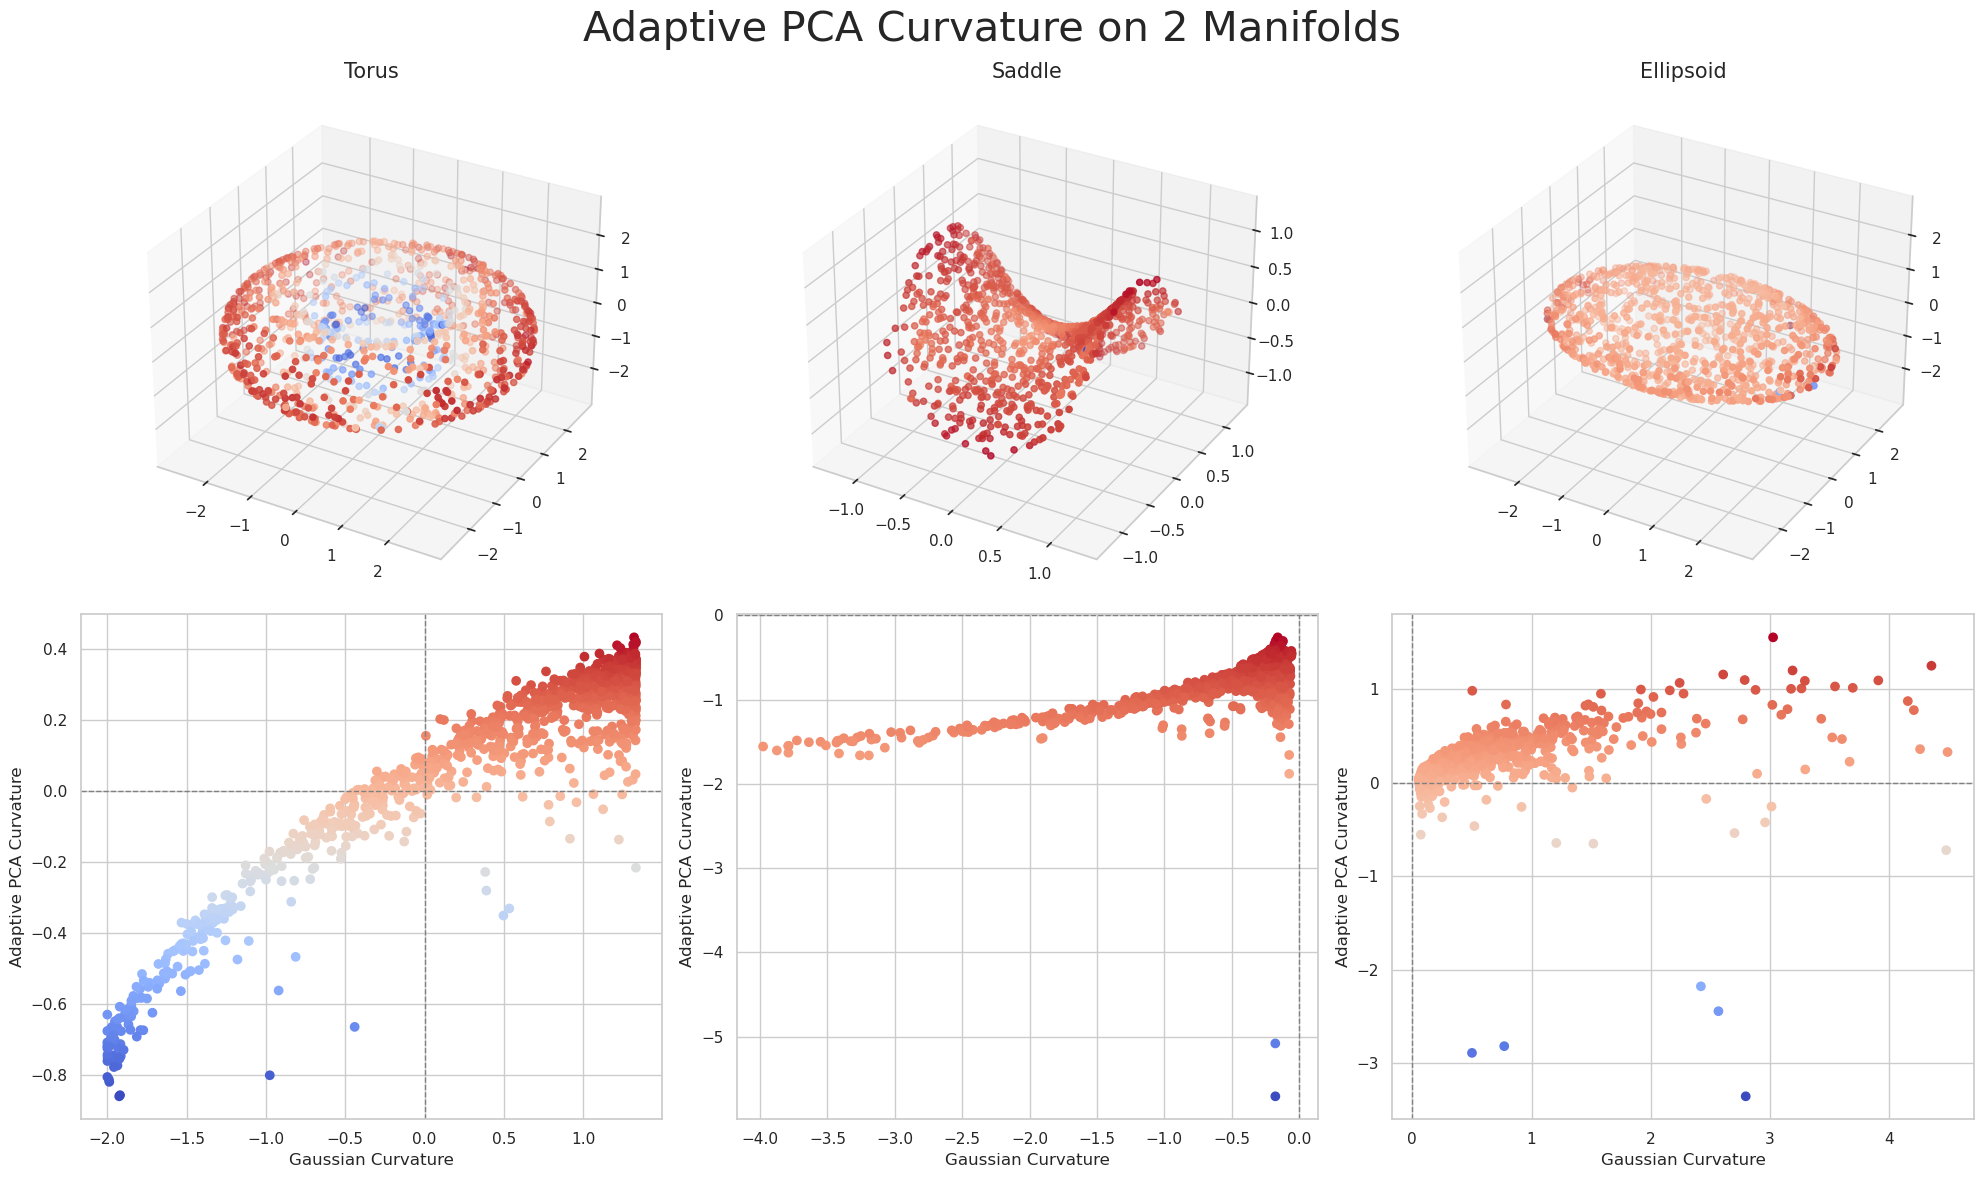

In [ ]:
#| label: fig-2-manifolds
#| fig-cap: Diffusion Curvature vs Gaussian Curvature on 2-Manifolds.
#| fig-alt: The Torus, Saddle, Ellipsoid are shown in the first row, colored by the diffusion curvature. The second row shows the scatter plot of the Gaussian curvature vs the diffusion curvature, colored by the diffusion curvature. The origin lines are highlighted in the scatter plots.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Saddle', 'Ellipsoid']
labels = diffusion_ks
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    if plt.matplotlib.__version__ >= '3.4.0':
        axs[0, i].remove()
        axs[0, i] = fig.add_subplot(2, 3, i+1, projection='3d')

    axs[0, i].axes.set_xlim3d(left=-lim, right=lim)
    axs[0, i].axes.set_ylim3d(bottom=-lim, top=lim)
    axs[0, i].axes.set_zlim3d(bottom=-lim, top=lim)
    scatter3d = axs[0, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=labels[key], cmap='coolwarm')
    axs[0, i].set_title(f'{key}',fontsize=15)

    # Scatter plot for the second row, colored by labels
    axs[1, i].remove()
    axs[1, i] = fig.add_subplot(2, 3, i+4)
    scatter2d = axs[1, i].scatter(ground_truth_labels[key], labels[key], c=labels[key], cmap='coolwarm')
    # axs[1, i].set_title(f'')
    axs[1, i].set_xlabel('Gaussian Curvature')
    axs[1, i].set_ylabel('Adaptive PCA Curvature')
    
    # Highlight the origin lines in 2D scatter plots
    axs[1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Adaptive PCA Curvature on 2 Manifolds", fontsize=30)
plt.tight_layout()
plt.show()


Normalize data by removing outliers.

In [ ]:
import numpy as np
from scipy import stats
def remove_outliers(data):
    # Calculate the Z-scores
    z_scores = np.abs(stats.zscore(data))
    
    # Filter the data
    filtered_data = data.copy()
    filtered_data[z_scores > 3] = 0
    return filtered_data

In [ ]:
filtered_ks = {}
for d in diffusion_ks.keys():
    filtered_ks[d] = remove_outliers(diffusion_ks[d])

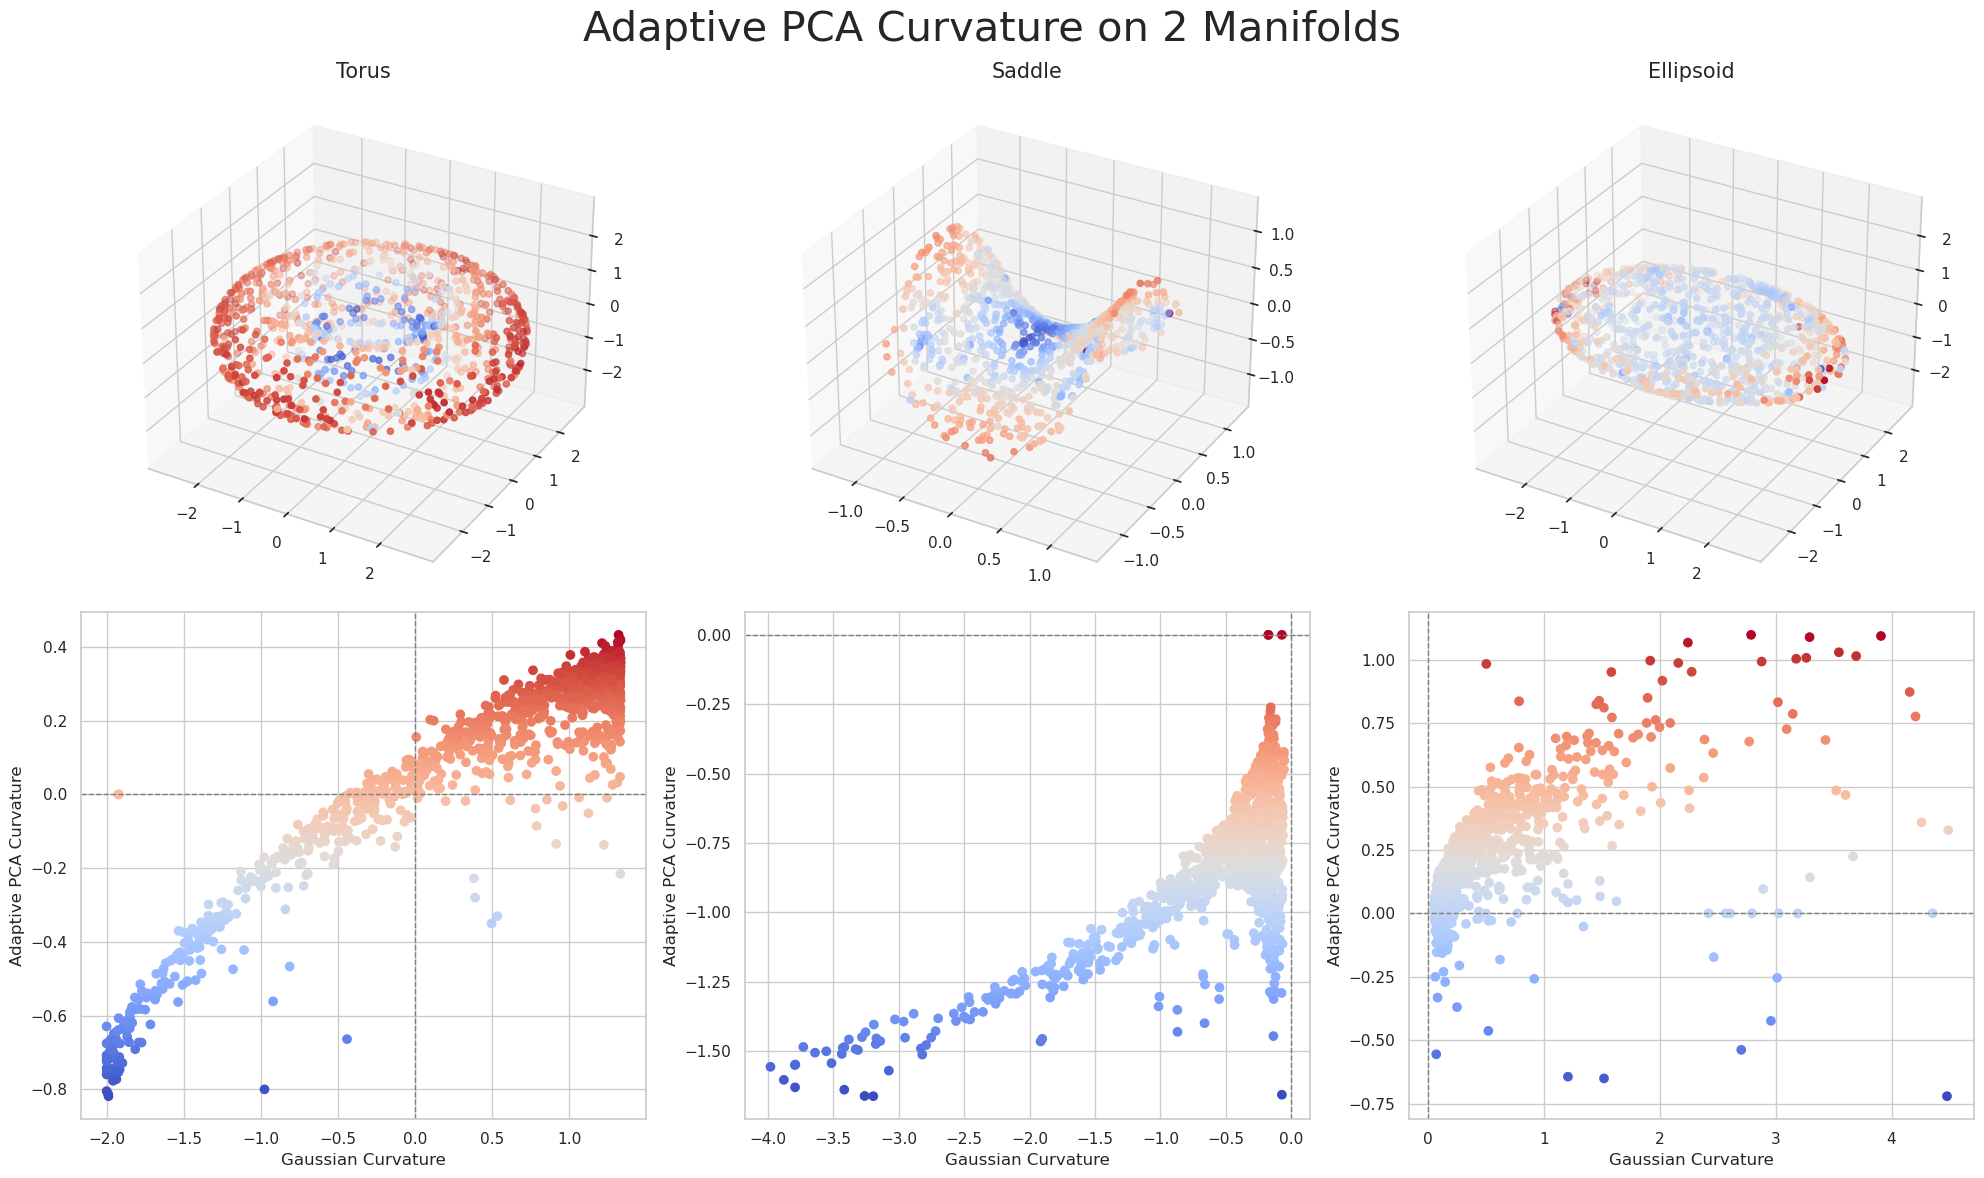

In [ ]:
#| label: fig-2-manifolds
#| fig-cap: Diffusion Curvature vs Gaussian Curvature on 2-Manifolds.
#| fig-alt: The Torus, Saddle, Ellipsoid are shown in the first row, colored by the diffusion curvature. The second row shows the scatter plot of the Gaussian curvature vs the diffusion curvature, colored by the diffusion curvature. The origin lines are highlighted in the scatter plots.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Saddle', 'Ellipsoid']
labels = filtered_ks
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    if plt.matplotlib.__version__ >= '3.4.0':
        axs[0, i].remove()
        axs[0, i] = fig.add_subplot(2, 3, i+1, projection='3d')

    axs[0, i].axes.set_xlim3d(left=-lim, right=lim)
    axs[0, i].axes.set_ylim3d(bottom=-lim, top=lim)
    axs[0, i].axes.set_zlim3d(bottom=-lim, top=lim)
    scatter3d = axs[0, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=labels[key], cmap='coolwarm')
    axs[0, i].set_title(f'{key}',fontsize=15)

    # Scatter plot for the second row, colored by labels
    axs[1, i].remove()
    axs[1, i] = fig.add_subplot(2, 3, i+4)
    scatter2d = axs[1, i].scatter(ground_truth_labels[key], labels[key], c=labels[key], cmap='coolwarm')
    # axs[1, i].set_title(f'')
    axs[1, i].set_xlabel('Gaussian Curvature')
    axs[1, i].set_ylabel('Adaptive PCA Curvature')
    
    # Highlight the origin lines in 2D scatter plots
    axs[1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Adaptive PCA Curvature on 2 Manifolds", fontsize=30)
plt.tight_layout()
plt.show()


In [ ]:
# save results on toy datasets for later use
np.savez(f'../../results/toy_dataset_{method_name}.npz', **diffusion_ks)

In [ ]:
# save results on toy datasets for later use
np.savez(f'../../results/toy_dataset_{method_name}_filtered.npz', **filtered_ks)

In [ ]:
X, ks = ellipsoid(n_points, seed=19323)
X

In [ ]:
X, ks = ellipsoid(n_points, seed=19323)
X

In [ ]:
# save results on toy datasets for later use
np.savez(f'../../results/toy_datasets_ground_truth_curvatures_1000.npz', **Ks)

In [ ]:
np.savez('../../results/toy_data_saved_1000.npz', **Xs)

In [ ]:
filtered_ks['Saddle noise = 0.05']

array([ 0.00000000e+00, -2.46155584e+00, -6.94148960e-01, -0.00000000e+00,
       -8.59976094e-01,  9.11212277e+00, -5.29601762e+01, -6.97152855e+01,
       -1.01971725e+00, -4.37656520e+01, -7.24487071e+01,  9.48547170e+00,
       -5.74799639e+02, -6.00385974e-01,  0.00000000e+00, -5.11935546e-01,
       -1.35773359e+00,  6.85872115e+00,  0.00000000e+00,  1.86528229e+00,
        6.65578385e+01, -3.73422056e+01,  5.28580478e+01,  0.00000000e+00,
       -9.41377564e+01,  3.08989206e+02, -1.72417246e+00, -1.81626224e+01,
       -2.14080060e+01, -1.70651452e+01, -4.07152291e+01, -1.86719316e+01,
       -4.13384119e+00, -9.31567906e+00, -8.49932466e+01, -0.00000000e+00,
       -8.48788166e-01,  6.42139401e+00, -1.00340179e+00, -1.73812017e+00,
       -7.68885614e-01, -1.56208307e+00, -9.07303930e-01, -0.00000000e+00,
       -7.84492713e+00, -2.12434210e+02, -1.47518003e+00, -4.88798598e-01,
        2.26793336e+00,  2.99904562e+00, -1.44445462e+00, -1.73094348e+02,
       -1.37160414e+00,  